# Exploration: classification pipeline

This notebook aims at providing a working pipeline to test and evaluate the performances of implemented classification models. The pipeline carries the data through every step of preprocessing (cf. `/src/preprocessing.py`) and dataset splitting and reformatting before applying classification models.

## Notebook setup

In [47]:
# Run the following command to install the required packages:
# !pip install -r requirements.txt
# !pip install -e ../src

In [48]:
from preprocessing.train import process_train_data
from classif.optim import train_model
from classif.perfs import compute_prediction_scores, ROC_curve, PR_curve
from classif.utils import (save_model_dict,
                           save_model_full,
                           load_model_dict,
                           load_model_full,
                           predict_test)
from classif.models.cnn import CNN_Windows

In [49]:
from typing import Callable
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

## Data processing

### Data loading

This subsection allows to load the datasets containing the raw data of EEG recordings along with some useful meta-data.

In [50]:
PATH_DATA_FOLDER = os.path.join(os.getcwd(), '../data')
PATH_DATA_SAMPLE_FOLDER = f'{PATH_DATA_FOLDER}/sample'
PATH_DATA_MPLE_TRIAL1_FILE = f'{PATH_DATA_SAMPLE_FOLDER}/DATA_mple__Trial1.npy'
PATH_DATA_MPLE_TRIAL2_FILE = f'{PATH_DATA_SAMPLE_FOLDER}/DATA_mple__Trial2.npy'
PATH_DATA_P004_TRIAL1_FILE = f'{PATH_DATA_SAMPLE_FOLDER}/DATA_P_004_Trial1.npy'
PATH_DATA_P004_TRIAL2_FILE = f'{PATH_DATA_SAMPLE_FOLDER}/DATA_P_004_Trial2.npy'

# Load the data into numpy arrays
array_mple_t1 = np.load(PATH_DATA_MPLE_TRIAL1_FILE, allow_pickle=True)
array_p004_t1 = np.load(PATH_DATA_P004_TRIAL1_FILE, allow_pickle=True)

# Convert into dataframes
df_mple_t1 = pd.DataFrame(array_mple_t1)
df_p004_t1 = pd.DataFrame(array_p004_t1)

In [51]:
# Display one dataframe for example
df_p004_t1

,0
0,004
1,G
2,Trial1
3,125
4,"[D, [1805.0, 1806.0, 1807.0, 1808.0, 1809.0, 1..."
5,"[G, [1485.0, 1486.0, 1487.0, 1488.0, 1489.0, 1..."
6,P_004


### Class EEGData
This subsection creates a new class to load and preprocess the data

In [52]:
class EEGData:
    def __init__(self, path_data_file: str):
        self.eeg_array = np.load(path_data_file, allow_pickle=True)

        self.session_id = None
        self.AVC_side = None
        self.trial_id = None
        self.sampling_rate = 1024
        self.ch_names = None
        self.metadata = None
        
        self.windows = None  # np.ndarray[n_samples, n_electrods, len_windows]
        self.targets = None  # np.ndarray[n_samples]
    
    def preprocess(self, 
                   side='G', 
                   fs=1024, 
                   low_freq=10, 
                   high_freq=50, 
                   window_size=0.5, 
                   step_size=0.1, 
                   epoch_start_time=-1, 
                   epoch_end_time=1, 
                   start_time_label=-0.5, 
                   end_time_label=0, 
                   eeg_order=None, 
                   verbose=False
        ):
        
        data, meta_data = process_train_data(
            self.eeg_array, side, fs, low_freq, high_freq, window_size, 
            step_size, epoch_start_time, epoch_end_time, start_time_label, 
            end_time_label, eeg_order, verbose)
        self.session_id = meta_data['session_id']
        self.AVC_side = meta_data['AVC_side']
        self.trial_id = meta_data['trial_id']
        self.ch_names = meta_data['ch_names']
        
        self.meta_data = meta_data
        
        self.windows = data[0]
        self.targets = data[1]

In [53]:
PATH_DATA_FOLDER = './data'
PATH_DATA_SAMPLE_FOLDER = f'.{PATH_DATA_FOLDER}/sample'
PATH_DATA_MPLE_TRIAL1_FILE = f'{PATH_DATA_SAMPLE_FOLDER}/DATA_mple__Trial1.npy'

## Parameters for the sliding windows preprocessing
side = 'G'
fs = 1024   # Sampling frequency
low_freq = 10   # low frequency bound
high_freq = 50  # high frequency bound
epoch_start_time = -1
epoch_end_time = 2
window_size = 0.25
step_size = 0.1
pre_duration = -1
post_duration = 0

n_samples_windows = int(window_size*fs)
n_channels = 64

data = EEGData(PATH_DATA_MPLE_TRIAL1_FILE)
data.preprocess(
    side, fs, low_freq, high_freq, window_size, step_size, epoch_start_time, 
    epoch_end_time, pre_duration, post_duration, verbose=True)

INFO:root:
--- Loading data ---


Creating RawArray with float64 data, n_channels=64, n_times=245609
    Range : 0 ... 245608 =      0.000 ...   239.852 secs
Ready.


INFO:root:
--- Filtering data ---


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1353 samples (1.321 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
INFO:root:
--- Epoching data ---


Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 3073 original time points ...
0 bad epochs dropped


/media/Data/isae-supaero/3A/PIE/PIE_2023/src/preprocessing/train.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_epochs, n_channels, n_times = epochs.get_data().shape
/media/Data/isae-supaero/3A/PIE/PIE_2023/src/preprocessing/train.py:43: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data = epochs.get_data()[epoch_idx]
/media/Data/isae-supaero/3A/PIE/PIE_2023/src/preprocessing/train.py:43: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data = epochs.get_data()[epoch_idx]
/media/Data/isae-supaero/3A/PIE/PIE_2023/src/preprocessing/train.py:43: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data = epo

In [54]:
print(data.windows.shape)
print(data.targets.shape)

(280, 64, 256)
(280,)


### Data splitting

This subsection provides splits of the dataset to created training, validation and testing sets. The proportion that each set represent is as follows:

- `train_dataset` = $80\%$ of $80\%$ of `dataset` = $64\%$ of the full dataset
- `valid_dataset` = $20\%$ of $80\%$ of `dataset` = $16\%$ of the full dataset
- `test_dataset`  = $20\%$ of `dataset`

Note that the dataset is highly disproportionate between samples labeled $0$ (non-motion) and samples labeled $1$ (motion). Hence, we make sure to keep a representative distribution of the samples when splitting the datasets !

In [55]:
# Train / test split
indx_0 = np.where(data.targets == 0)[0]
indx_1 = np.where(data.targets == 1)[0]
np.random.shuffle(indx_0)
np.random.shuffle(indx_1)

train_0_indx = indx_0[:int(len(indx_0)*0.8)]
test_0_indx = indx_0[int(len(indx_0)*0.8):]
train_1_indx = indx_1[:int(len(indx_1)*0.8)]
test_1_indx = indx_1[int(len(indx_1)*0.8):]

train_indx = np.concatenate((train_0_indx, train_1_indx))
test_indx = np.concatenate((test_0_indx, test_1_indx))

trains_windows = data.windows[train_indx, :, :]
trains_targets = data.targets[train_indx]
test_windows = data.windows[test_indx, :, :]
test_targets = data.targets[test_indx]


In [56]:
# Train / valid split
indx_0 = np.where(trains_targets == 0)[0]
indx_1 = np.where(trains_targets == 1)[0]
np.random.shuffle(indx_0)
np.random.shuffle(indx_1)

train_0_indx = indx_0[:int(len(indx_0)*0.8)]
valid_0_indx = indx_0[int(len(indx_0)*0.8):]
train_1_indx = indx_1[:int(len(indx_1)*0.8)]
valid_1_indx = indx_1[int(len(indx_1)*0.8):]

train_indx = np.concatenate((train_0_indx, train_1_indx))
valid_indx = np.concatenate((valid_0_indx, valid_1_indx))

train_windows = trains_windows[train_indx, :, :]
train_targets = trains_targets[train_indx]
valid_windows = trains_windows[valid_indx, :, :]
valid_targets = trains_targets[valid_indx]


In [57]:
# Verify split went well
print("train windows shape: ", train_windows.shape)
print("train targets shape: ", train_targets.shape)
print("valid windows shape: ", valid_windows.shape)
print("valid targets shape: ", valid_targets.shape)

print(np.unique(train_targets, return_counts=True))
print(np.unique(valid_targets, return_counts=True))

print("test windows shape: ", test_windows.shape)
print("test targets shape: ", test_targets.shape)
print(np.unique(test_targets, return_counts=True))

train windows shape:  (178, 64, 256)
train targets shape:  (178,)
valid windows shape:  (45, 64, 256)
valid targets shape:  (45,)
(array([0, 1]), array([99, 79]))
(array([0, 1]), array([25, 20]))
test windows shape:  (57, 64, 256)
test targets shape:  (57,)
(array([0, 1]), array([32, 25]))


In [58]:
# Add cell to perform under/over sampling ?

### Dataset definition + loaders

Here we define a dataset class that can be used in `torch` dataloaders in order to perform batch training.

In [59]:
X_train = train_windows
y_train = train_targets
X_valid = valid_windows
y_valid = valid_targets
X_test = test_windows
y_test = test_targets

In [60]:
# Compute statistics of the dataset
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [61]:
class NpArrayDataset(Dataset):
    def __init__(
        self,
        windows: np.ndarray,
        targets: np.ndarray,
        windows_transforms: Callable = None,
        targets_transforms: Callable = None,
    ):
        self.windows = windows
        self.targets = targets
        self.windows_transforms = windows_transforms
        self.targets_transforms = targets_transforms

    def __len__(self):
        return self.windows.shape[0]

    def __getitem__(self, index: int):
        x = self.windows[index]
        y = self.targets[index]

        if self.windows_transforms is not None:
            x = self.windows_transforms(x)
        else:
            x = torch.tensor(x)

        if self.targets_transforms is not None:
            y = self.targets_transforms(y)
        else:
            y = torch.tensor(y)

        x = x.float()
        y = y.float()
        return x, y

In [62]:
BATCH_SIZE = 16 # 128

# Data loading
windows_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
targets_transforms = None

# load the training data
train_set = NpArrayDataset(
    windows=train_windows,
    targets=train_targets,
    windows_transforms=windows_transforms,
    targets_transforms=targets_transforms,
)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# load the validation data
valid_set = NpArrayDataset(
    windows=valid_windows,
    targets=valid_targets,
    windows_transforms=windows_transforms,
    targets_transforms=targets_transforms,
)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

In [63]:
len(train_loader)

12

## Classification

With the data now as clean as possible, it is time to choose and train a classification model.

In [68]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

X_train_bis = X_train.mean(axis=1)
X_test_bis = X_test.mean(axis=1)

clf = SVC(kernel='rbf')
clf.fit(X_train_bis, y_train)

y_pred = clf.predict(X_test_bis)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")


Accuracy: 0.5263157894736842
F1-score: 0.0


### Training

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

In [ ]:
# Classifier choice
MODEL_NAME = "CNN_Windows"
MODEL_PATH = "models/" + MODEL_NAME + "_" + data.session_id + ".pt"
model = CNN_Windows(nb_channels=n_channels, 
                    windows_len=n_samples_windows)
# model.summary()

# Send to DEVICE
model = model.to(DEVICE)
model = model.float()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
criterion = nn.BCELoss()


In [ ]:
# First training
train_loss, valid_loss = train_model(model, 
                                     optimizer, 
                                     criterion,
                                     EPOCHS,
                                     train_loader,
                                     valid_loader,
                                     DEVICE,
                                     early_stop=False, 
                                     early_cntr=5,
                                     checkpoint=True, 
                                     model_path=MODEL_PATH)


Batch     0, curr loss = 68.750
Batch     2, curr loss = 81.250
Batch     4, curr loss = 68.750
Batch     6, curr loss = 56.250
Batch     8, curr loss = 43.750
Batch    10, curr loss = 56.250
EPOCH=0, TRAIN=51.5625, VALID=55.448717753092446
Batch     0, curr loss = 43.750
Batch     2, curr loss = 56.250
Batch     4, curr loss = 43.750
Batch     6, curr loss = 56.250
Batch     8, curr loss = 50.000
Batch    10, curr loss = 56.250
EPOCH=1, TRAIN=58.854166666666664, VALID=55.92948659261068
Batch     0, curr loss = 62.500
Batch     2, curr loss = 56.250
Batch     4, curr loss = 31.250
Batch     6, curr loss = 43.750
Batch     8, curr loss = 62.500
Batch    10, curr loss = 62.500
EPOCH=2, TRAIN=58.854166666666664, VALID=56.410255432128906
Batch     0, curr loss = 62.500
Batch     2, curr loss = 56.250
Batch     4, curr loss = 37.500
Batch     6, curr loss = 56.250
Batch     8, curr loss = 50.000
Batch    10, curr loss = 62.500
EPOCH=3, TRAIN=58.854166666666664, VALID=54.48718007405599
Batch

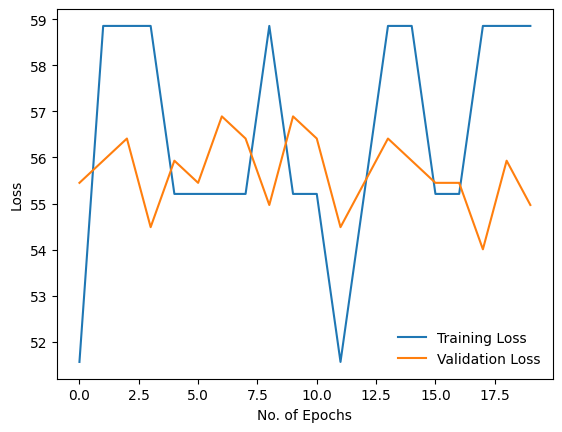

In [ ]:
# Plot training / validation loss
plt.plot(train_loss, label="Training Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

### Metrics & performances

In [ ]:
# Define test dataset
test_ds = NpArrayDataset(
    windows=test_windows,
    targets=test_targets,
    windows_transforms=windows_transforms,
    targets_transforms=targets_transforms,
)

In [ ]:
# Perform predictions
import tqdm

y_true = []
y_pred = []
threshold = 0.5

# Send model to correct device
model.to(DEVICE)
# Put model in evaluatio mode (very important)
model.eval()

# Disable all gradients things
with torch.no_grad():
    for x, y_t in tqdm.tqdm(test_ds, "predicting"):
        x = x.reshape((-1,) + x.shape)
        x = x.to(DEVICE)
        y = model.forward(x)
        y = y.to("cpu").numpy()
        y_t = int(y_t.to("cpu").numpy())
        y_pred.append(y)
        y_true.append(y_t)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.asarray(y_true)

predicting: 100%|██████████| 32/32 [00:00<00:00, 963.67it/s]


In [ ]:
compute_prediction_scores(y_true, y_pred, verbose=True)

TN: 0,
FP: 32,
FN: 0,
TP: 0
Accuracy : 0.0
Recall   : 0.0
Precision: 0.0
F1: 0.0


/media/Data/envs/EEGstroke/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tn': 0,
 'fp': 32,
 'fn': 0,
 'tp': 0,
 'acc': 0.0,
 'rec': 0.0,
 'pre': 0.0,
 'f1': 0.0}

#### ROC curves

ROC AUC: nan


/media/Data/envs/EEGstroke/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


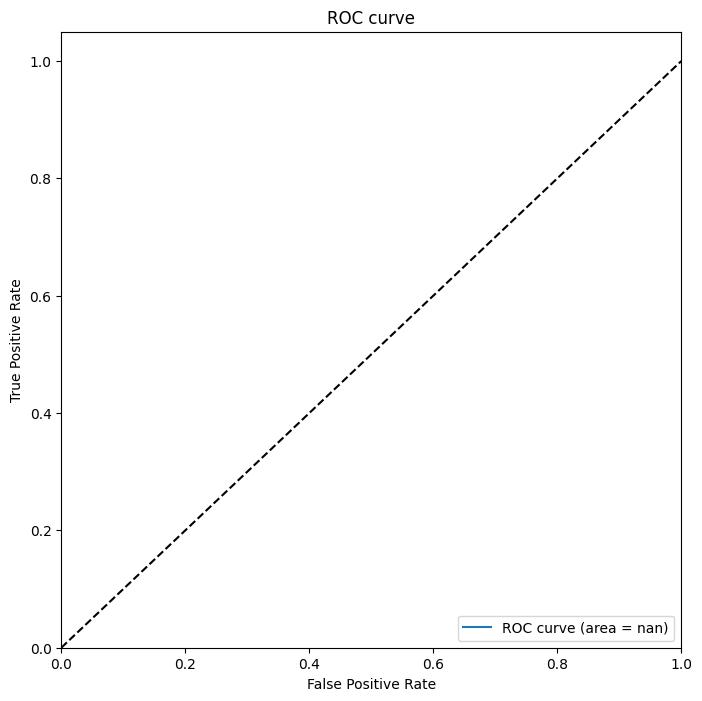

AttributeError: FancyArrowPatch.set() got an unexpected keyword argument 'shrink'

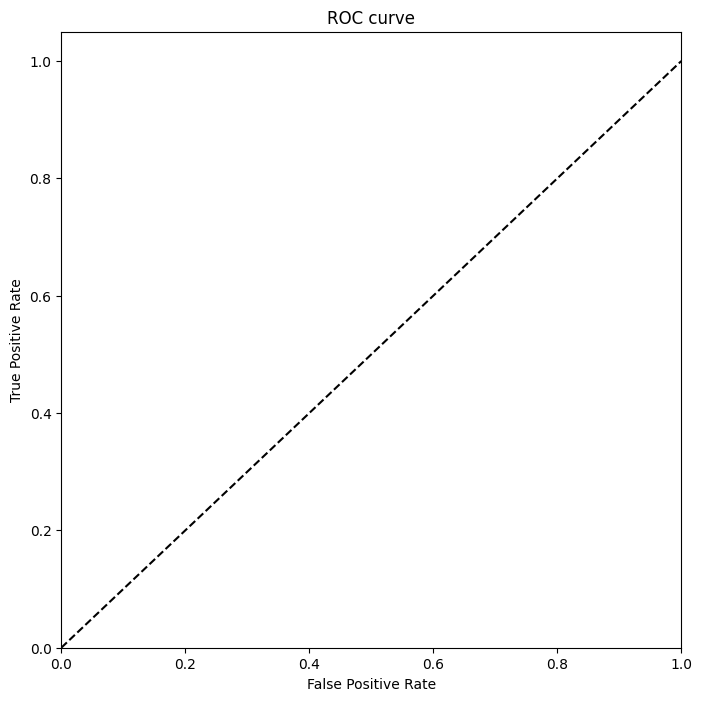

In [ ]:
# We round predictions every 0.05 for readability
y_pred_probas = (y_pred[:, 0] / 0.05).astype(int) * 0.05
ROC_curve(y_true, y_pred_probas, verbose=True, display=True, savefig=False)

In [ ]:
# Select best threshold
best_threshold = 0.5

#### PR curves (precision-recall)

In [ ]:
# We round predictions for better readability
y_pred_probas = np.round(y_pred[:, 0], 2)

PR_curve(y_true, y_pred_probas, verbose=True, display=True, savefig=False)


In [ ]:
# Select best threshold
best_threshold = 0.5

#### F1 scores 

In [ ]:
# Select best threshold
best_threshold = 0.5

#### Final predictions using best threshold

In [ ]:
y_pred_classes = y_pred_probas > best_threshold


#### Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print("Confusion matrix")
cmat = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cmat,
    display_labels=["background", "aircraft"]
)

disp.plot()
plt.show()

### Save model

In [ ]:
save_model(model, MODEL_PATH, mode='jit')

## Prédictions

In [ ]:
# import sklearn.metrics
# import math
# tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_norm, y_pred_norm).ravel()
# print("True positives:", tp)
# print("True negatives:", tn)
# print("False positives:", fp)
# print("False negatives:", fn)
# print("Accuracy:", (tp+tn)/len(y_test_norm))
# print("Sensitivity:", sen:=tp/(tp+fn))
# print("Precision:", pre:=tp/(tp+fp))
# print("Fowlkes-Mallows:", math.sqrt(sen*pre))